In [1]:
import pandas as pd
import numpy as np
import requests
import json
import xmltodict
from rdkit import Chem
from mordred import Calculator, descriptors
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [7]:
pip install 'numpy>=1.20,<1.24'
# verzija niz od 1.24 zbog problema s numpy float

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Učitavanje podataka

In [3]:
path = "/content/drive/My Drive/kemoinf/data/dopamine.csv"
# path = "./data/dopamine.csv

In [4]:
data = pd.read_csv(path, index_col=0)
data

,ChEMBL_ID,pIC50
0,CHEMBL303519,5.01
1,CHEMBL292943,7.30
2,CHEMBL61682,7.60
3,CHEMBL64487,6.44
4,CHEMBL64597,6.52
...,...,...
474,CHEMBL3805434,7.42
475,CHEMBL3805327,7.23
476,CHEMBL3805262,5.80
477,CHEMBL3805515,6.70


### 2. Dohvaćanje SMILES zapisa

Retrieve SMILES representation for each molecule using the ChEMBL REST API through your Python environment.

Make SMILES canonical by using rdkit Python package.

In [5]:
smiles = []
for mol_id in data.ChEMBL_ID:
    response = requests.get(f'https://www.ebi.ac.uk/chembl/api/data/molecule/{mol_id}')
    smiles.append(Chem.CanonSmiles(xmltodict.parse(response.text)['molecule']['molecule_structures']['canonical_smiles']))
data['smiles'] = smiles
# data.to_csv('./data/temp.csv', index=False)

In [6]:
data

,ChEMBL_ID,pIC50,smiles
0,CHEMBL303519,5.01,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1
1,CHEMBL292943,7.30,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1
2,CHEMBL61682,7.60,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1
3,CHEMBL64487,6.44,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1
4,CHEMBL64597,6.52,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1
...,...,...,...
474,CHEMBL3805434,7.42,CNC(=O)c1cc(OCCCCN2CCN(c3cccc(Cl)c3Cl)CC2)cc(C...
475,CHEMBL3805327,7.23,CNC(=O)c1ccc(Cl)c(OCCCCN2CCN(c3cccc(Cl)c3Cl)CC...
476,CHEMBL3805262,5.80,CNC(=O)c1cc(F)cc(OCCCCN2CCN(c3cccc(Cl)c3Cl)CC2)c1
477,CHEMBL3805515,6.70,CNC(=O)c1cccc(OCCCCN2CCN(c3cccc(Cl)c3Cl)CC2)c1OC


### 3. Računanje moleklularnih deskriptora
Calculate molecular descriptors by using Mordred Python package or some other available molecular descriptor calculator. Use all available 0D, 1D, 2D and 3D molecular descriptors


- 0D descriptors: Molecular weight, atom count, etc.
- 1D descriptors: Simple structural features
- 2D descriptors: Topological and connectivity-based descriptors
- 3D descriptors: Geometric and spatial characteristics

https://mordred-descriptor.github.io/documentation/master/descriptors.html

- TODO prouciti moze li se kako rijesiti overflow error (zasad nisam nasla rjesenje)
https://www.rdkit.org/docs/GettingStartedInPython.html

In [87]:
from rdkit.Chem import AllChem

def calculate_molecular_descriptors(smiles_list):
    """
    Calculate molecular descriptors for a list of SMILES strings using Mordred.

    Parameters:
    smiles_list (list): List of SMILES strings

    Returns:
    pd.DataFrame: DataFrame with molecular descriptors
    """
    # Create a Mordred calculator with all descriptors
    calc = Calculator(descriptors, ignore_3D=False)

    # Convert SMILES to RDKit mol objects
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

    # Remove any None molecules (invalid SMILES)
    valid_mols = [mol for mol in mols if mol is not None]
    valid_smiles = [Chem.MolToSmiles(mol) for mol in valid_mols]

    for mol in valid_mols:
        AllChem.Compute2DCoords(mol)
        mol = Chem.AddHs(mol)
        params = AllChem.ETKDGv3()
        params.randomSeed = 0xf00d # optional random seed for reproducibility
        AllChem.EmbedMolecule(mol, params)
        try:
          AllChem.MMFFOptimizeMolecule(mol)
        except ValueError as e:
          print(f"Optimization failed for molecule: {Chem.MolToSmiles(mol)}. Error: {e}")
          continue

    # Calculate descriptors
    descriptors_df = calc.pandas(valid_mols)

    # Add SMILES column to the descriptors DataFrame
    descriptors_df.insert(0, 'SMILES', valid_smiles)

    return descriptors_df

molecular_descriptors = calculate_molecular_descriptors(data['smiles'])

# Combine original data with descriptors
combined_data = pd.concat([data, molecular_descriptors.drop('SMILES', axis=1)], axis=1)
combined_data.to_csv('./combined_molecular_data.csv', index=False)

print(f"Total number of descriptors calculated: {molecular_descriptors.shape[1] - 1}")
print("Descriptor names:")
print(molecular_descriptors.columns[1:].tolist())

[02:07:35] UFFTYPER: Unrecognized charge state for atom: 21
[02:07:35] UFFTYPER: Unrecognized charge state for atom: 21


Optimization failed for molecule: [H]Oc1c(OC([H])([H])C([H])([H])C([H])([H])N([H])C(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)N([H])C([H])([H])C([H])([H])C([H])([H])Oc2c([H])c([H])c3c(c2O[H])-c2c([H])c([H])c([H])c4c2[C@]([H])(N(C([H])([H])[H])C([H])([H])C4([H])[H])C3([H])[H])c([H])c([H])c2c1-c1c([H])c([H])c([H])c3c1[C@]([H])(N(C([H])([H])[H])C([H])([H])C3([H])[H])C2([H])[H]. Error: Bad Conformer Id
Optimization failed for molecule: [H]Oc1c(OC([H])([H])C([H])([H])C([H])([H])N([H])C(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)N([H])C([H])([H])C([H])([H])C([H])([H])Oc2c([H])c([H])c3c(c2O[H])-c2c([H])c([H])c([H])c4c2[C@]([H])(N(C([H])([H])[H])C([H])([H])C4([H])[H])C3([H])[H])c([H])c([H])c2c1

  3%|▎         | 15/479 [00:05<02:41,  2.88it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 18%|█▊        | 86/479 [00:28<02:03,  3.19it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 479/479 [03:01<00:00,  2.64it/s]


Total number of descriptors calculated: 1826
Descriptor names:
['ABC', 'ABCGG', 'nAcid', 'nBase', 'SpAbs_A', 'SpMax_A', 'SpDiam_A', 'SpAD_A', 'SpMAD_A', 'LogEE_A', 'VE1_A', 'VE2_A', 'VE3_A', 'VR1_A', 'VR2_A', 'VR3_A', 'nAromAtom', 'nAromBond', 'nAtom', 'nHeavyAtom', 'nSpiro', 'nBridgehead', 'nHetero', 'nH', 'nB', 'nC', 'nN', 'nO', 'nS', 'nP', 'nF', 'nCl', 'nBr', 'nI', 'nX', 'ATS0dv', 'ATS1dv', 'ATS2dv', 'ATS3dv', 'ATS4dv', 'ATS5dv', 'ATS6dv', 'ATS7dv', 'ATS8dv', 'ATS0d', 'ATS1d', 'ATS2d', 'ATS3d', 'ATS4d', 'ATS5d', 'ATS6d', 'ATS7d', 'ATS8d', 'ATS0s', 'ATS1s', 'ATS2s', 'ATS3s', 'ATS4s', 'ATS5s', 'ATS6s', 'ATS7s', 'ATS8s', 'ATS0Z', 'ATS1Z', 'ATS2Z', 'ATS3Z', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS7Z', 'ATS8Z', 'ATS0m', 'ATS1m', 'ATS2m', 'ATS3m', 'ATS4m', 'ATS5m', 'ATS6m', 'ATS7m', 'ATS8m', 'ATS0v', 'ATS1v', 'ATS2v', 'ATS3v', 'ATS4v', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS8v', 'ATS0se', 'ATS1se', 'ATS2se', 'ATS3se', 'ATS4se', 'ATS5se', 'ATS6se', 'ATS7se', 'ATS8se', 'ATS0pe', 'ATS1pe', 'ATS2pe', 'ATS3pe'

In [88]:
combined_data.head()

,ChEMBL_ID,pIC50,smiles,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,CHEMBL303519,5.01,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,21.011003,14.920944,0,1,35.835568,2.504877,4.869002,...,10.266776,75.682997,342.184447,7.128843,1797,42,144.0,173.0,5.388889,5.638889
1,CHEMBL292943,7.30,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,21.132323,14.720991,0,1,36.522379,2.360154,4.720308,...,10.083765,61.954496,360.195011,7.062647,2172,40,140.0,162.0,6.527778,6.055556
2,CHEMBL61682,7.60,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1,21.310663,15.088212,0,1,35.81174,2.370165,4.74033,...,10.141362,62.103563,365.170354,7.607716,2130,41,142.0,165.0,7.138889,5.916667
3,CHEMBL64487,6.44,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1,21.091883,15.171089,0,1,36.528506,2.378509,4.757019,...,10.117429,62.012532,360.195011,7.062647,2096,41,140.0,163.0,6.527778,6.083333
4,CHEMBL64597,6.52,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1,19.011003,14.059124,0,1,32.579628,2.356613,4.698085,...,9.949655,71.503368,336.140868,7.639565,1532,33,126.0,146.0,5.166667,5.305556


### 4. Čišćenje podataka
Clean the transformed data of missing values and outliers. Remove duplicates.

- Nema duplikata.
- Kako definiramo outliere? Na temelju čega? - dodati box plotove po svakom deskriptoru??

In [89]:
combined_data['smiles'].duplicated().sum()

0

In [90]:
# Problem s 3D deskriptorima - kako rijesiti?????
combined_data['MOMI-Z'].head()

,MOMI-Z
0,missing 3D coordinate (MOMI-X/mordred.MomentOf...
1,missing 3D coordinate (MOMI-X/mordred.MomentOf...
2,missing 3D coordinate (MOMI-X/mordred.MomentOf...
3,missing 3D coordinate (MOMI-X/mordred.MomentOf...
4,missing 3D coordinate (MOMI-X/mordred.MomentOf...


In [91]:
# Problem s 3D deskriptorima - kako rijesiti?????
combined_data['PNSA1'].head()

,PNSA1
0,missing 3D coordinate (PNSA1/AtomicSurfaceArea)
1,missing 3D coordinate (PNSA1/AtomicSurfaceArea)
2,missing 3D coordinate (PNSA1/AtomicSurfaceArea)
3,missing 3D coordinate (PNSA1/AtomicSurfaceArea)
4,missing 3D coordinate (PNSA1/AtomicSurfaceArea)


In [92]:
# Problem s 2D deskriptorima - kako rijesiti?????
combined_data['MDEN-11'].head()

,MDEN-11
0,float division by zero (MDEN-11)
1,float division by zero (MDEN-11)
2,float division by zero (MDEN-11)
3,float division by zero (MDEN-11)
4,float division by zero (MDEN-11)


In [93]:
# Preserve ChEMBL_ID and smiles as strings
string_columns_to_preserve = ['ChEMBL_ID', 'smiles']

# columns that need numeric conversion
columns_to_convert = [col for col in combined_data.columns if col not in string_columns_to_preserve]

for col in columns_to_convert:
    try:
        combined_data[col] = pd.to_numeric(combined_data[col], errors='coerce')
    except Exception as e:
        print(f"Could not convert {col}: {e}")

# Verify data types
print("\nColumn data types after conversion:")
print(combined_data.dtypes)


Column data types after conversion:
ChEMBL_ID     object
pIC50        float64
smiles        object
ABC          float64
ABCGG        float64
              ...   
WPol           int64
Zagreb1      float64
Zagreb2      float64
mZagreb1     float64
mZagreb2     float64
Length: 1829, dtype: object


In [94]:
null_counts = combined_data.isnull().sum()
columns_with_nulls = null_counts[null_counts == 479]
print(columns_with_nulls)

PNSA1      479
PNSA2      479
PNSA3      479
PNSA4      479
PNSA5      479
          ... 
MDEN-11    479
MOMI-X     479
MOMI-Y     479
MOMI-Z     479
PBF        479
Length: 320, dtype: int64


**3D DESKRIPTORI IMAJU VRIJEDNOST NAN JER PRIJE KONVERZIJE BUDU - missing 3D coordinate ..., 2D ZBOG DIJELJENJA S 0**

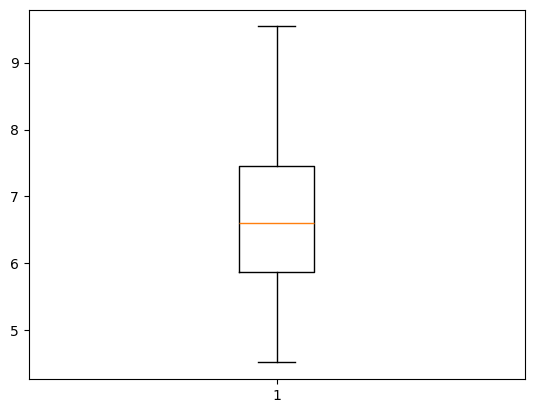

In [95]:
# boxplot značajke koju bismo trebali predvidjeti
# nema outliera
plt.boxplot(combined_data['pIC50'])
plt.show()

### 5. Splitting
Split the preprocessed dataset into subset for training and subset for testing in ratio 75:25. If using deep learning, split into subset for validation as well (ratio 70:15:15)

In [96]:
train, test = train_test_split(combined_data, test_size=0.25)

train_DL, test_DL = train_test_split(combined_data, test_size=0.3)
validate_DL, test_DL = train_test_split(test_DL, test_size=0.5)


### 6. Skaliranje podataka
Define and initialize scaler by using Scikit-learn Python package. Scale the data appropriately.

- https://scikit-learn.org/1.5/modules/preprocessing.html -> trebalo bi proučiti i odabrati scaler na temelju značajki (?)